<a href="https://colab.research.google.com/github/sreeja-01p/Diabetic-Retinopathy/blob/main/dr2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_csv ='/content/drive/MyDrive/dataset/train.csv'
train_image_dir ='/content/drive/MyDrive/dataset/train_images'

In [ ]:
test_csv = '/content/drive/MyDrive/dataset/test.csv'
test_image_dir ='/content/drive/MyDrive/dataset/test_images'

In [ ]:
class DRDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.dataframe.iloc[idx, 0]}.png")
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx, 1] if 'diagnosis' in self.dataframe.columns else -1

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
trainLabels = pd.read_csv(train_csv)
print(trainLabels.head())

        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


In [ ]:
#testLabels = pd.read_csv(test_csv)
#print(testLabels.head())

        id_code
0  0005cfc8afb6
1  003f0afdcd15
2  006efc72b638
3  00836aaacf06
4  009245722fa4


In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
#train_df, val_df = train_test_split(trainLabels, train_size=0.8, shuffle=True, random_state=1)

In [ ]:
train_val_df, test_df = train_test_split(trainLabels, train_size=0.8, shuffle=True, random_state=1)

In [ ]:
train_df, val_df = train_test_split(train_val_df, train_size=0.9, shuffle=True, random_state=1)

In [ ]:
print(f"Train samples: {len(train_df)}, Validation samples: {len(val_df)}, Test samples: {len(test_df)}")

Train samples: 2636, Validation samples: 293, Test samples: 733


In [ ]:
train_dataset = DRDataset(train_df, train_image_dir, transform=data_transforms)
val_dataset = DRDataset(val_df, train_image_dir, transform=data_transforms)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
#test_dataset = DRDataset(testLabels, test_image_dir, transform=data_transforms)
test_dataset = DRDataset(test_df, train_image_dir, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
print(trainLabels.columns)
print(trainLabels.head())

Index(['id_code', 'diagnosis'], dtype='object')
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


<ipython-input-15-ef0e94c76488>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index, y=vc, palette="rocket")


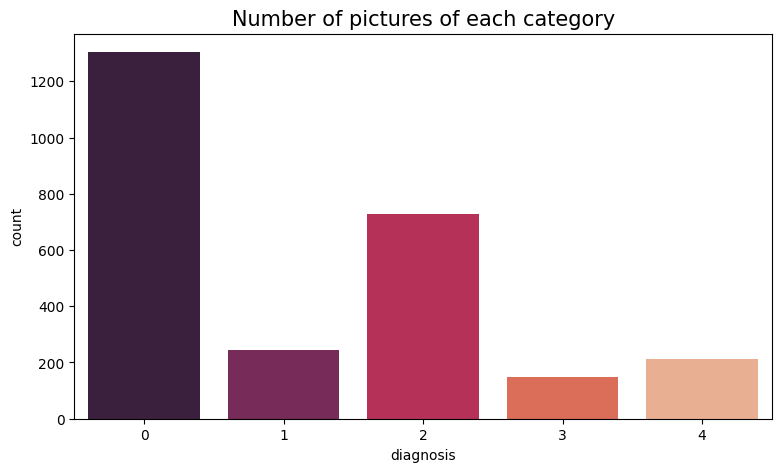

In [ ]:
vc = train_df['diagnosis'].value_counts()
plt.figure(figsize=(9, 5))
sns.barplot(x=vc.index, y=vc, palette="rocket")
plt.title("Number of pictures of each category", fontsize=15)
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (f"running on:{device}")

running on:cpu


In [ ]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  #Freeze pretrained layers

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 94.2MB/s]


In [ ]:
num_classes = trainLabels['diagnosis'].nunique()
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, num_classes)
)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    #training
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    #validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, "
          f"Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
          f"Val Acc: {val_accs[-1]:.4f}")

Epoch 1/10: 100%|██████████| 83/83 [33:52<00:00, 24.48s/it]


Epoch 1/10, Train Loss: 0.9501, Train Acc: 0.6593, Val Loss: 0.7716, Val Acc: 0.7065


Epoch 2/10: 100%|██████████| 83/83 [20:15<00:00, 14.64s/it]


Epoch 2/10, Train Loss: 0.7522, Train Acc: 0.7231, Val Loss: 0.7238, Val Acc: 0.7099


Epoch 3/10: 100%|██████████| 83/83 [20:17<00:00, 14.66s/it]


Epoch 3/10, Train Loss: 0.7156, Train Acc: 0.7386, Val Loss: 0.7032, Val Acc: 0.7304


Epoch 4/10: 100%|██████████| 83/83 [20:12<00:00, 14.61s/it]


Epoch 4/10, Train Loss: 0.6748, Train Acc: 0.7530, Val Loss: 0.7084, Val Acc: 0.7270


Epoch 5/10: 100%|██████████| 83/83 [20:09<00:00, 14.58s/it]


Epoch 5/10, Train Loss: 0.6966, Train Acc: 0.7303, Val Loss: 0.7224, Val Acc: 0.7338


Epoch 6/10: 100%|██████████| 83/83 [20:12<00:00, 14.61s/it]


Epoch 6/10, Train Loss: 0.6508, Train Acc: 0.7561, Val Loss: 0.6841, Val Acc: 0.7509


Epoch 7/10: 100%|██████████| 83/83 [20:09<00:00, 14.58s/it]


Epoch 7/10, Train Loss: 0.6476, Train Acc: 0.7568, Val Loss: 0.6779, Val Acc: 0.7543


Epoch 8/10: 100%|██████████| 83/83 [20:15<00:00, 14.64s/it]


Epoch 8/10, Train Loss: 0.6574, Train Acc: 0.7553, Val Loss: 0.6970, Val Acc: 0.7372


Epoch 9/10: 100%|██████████| 83/83 [20:19<00:00, 14.69s/it]


Epoch 9/10, Train Loss: 0.6313, Train Acc: 0.7595, Val Loss: 0.6773, Val Acc: 0.7474


Epoch 10/10: 100%|██████████| 83/83 [20:11<00:00, 14.59s/it]


Epoch 10/10, Train Loss: 0.6394, Train Acc: 0.7610, Val Loss: 0.7228, Val Acc: 0.7474


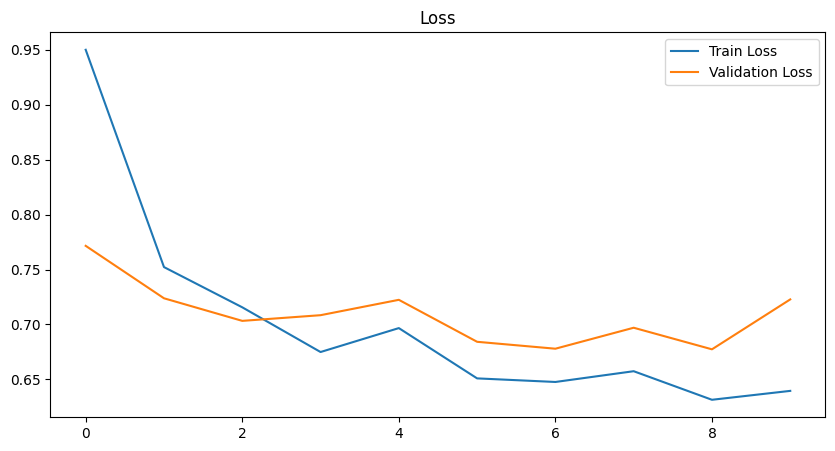

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.show()

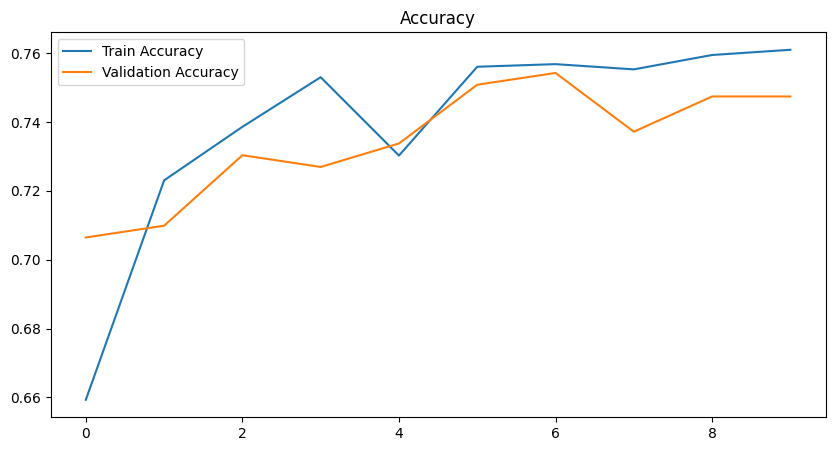

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

testing

In [28]:
model.eval()
predictions,true_labels = [],[]
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("Predictions for test set:", predictions[:10])

Predictions for test set: [1, 2, 0, 0, 0, 4, 2, 2, 2, 2]


In [30]:
print("True Labels:", true_labels[:10])

True Labels: [1, 2, 0, 0, 0, 3, 2, 2, 2, 2]


In [29]:
from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 76.81%
